In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import os

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
for dirname, _, filenames in os.walk('../inputs'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/mnt/c/Users/denad/OneDrive/Documents/GitHub/uefa-championship-analysis-1/.venv/lib/python3.10/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


../inputs/euro_coaches.csv
../inputs/euro_lineups.csv
../inputs/euro_summary.csv
../inputs/logos/ALB.png
../inputs/logos/AUT.png
../inputs/logos/BEL.png
../inputs/logos/BUL.png
../inputs/logos/CIS.png
../inputs/logos/CRO.png
../inputs/logos/CZE.png
../inputs/logos/DEN.png
../inputs/logos/ENG.png
../inputs/logos/ESP.png
../inputs/logos/FIN.png
../inputs/logos/FRA.png
../inputs/logos/FRG.png
../inputs/logos/GER.png
../inputs/logos/GRE.png
../inputs/logos/HUN.png
../inputs/logos/IRL.png
../inputs/logos/ISL.png
../inputs/logos/ITA.png
../inputs/logos/LVA.png
../inputs/logos/MKD.png
../inputs/logos/NED.png
../inputs/logos/NIR.png
../inputs/logos/NOR.png
../inputs/logos/POL.png
../inputs/logos/POR.png
../inputs/logos/ROU.png
../inputs/logos/SCO.png
../inputs/logos/SUI.png
../inputs/logos/SVK.png
../inputs/logos/SVN.png
../inputs/logos/SWE.png
../inputs/logos/TCH.png
../inputs/logos/TUR.png
../inputs/logos/UKR.png
../inputs/logos/WAL.png
../inputs/logos/YUG.png
../inputs/matches/friendly_2021

In [3]:
matches_path = '../inputs/matches/euro'

euro_2020 = pd.read_csv(f'{matches_path}/2020.csv')
euro_2020.head()

,id_match,home_team,away_team,home_team_code,away_team_code,home_score,away_score,home_penalty,away_penalty,home_score_total,...,penalties_missed,penalties,red_cards,game_referees,stadium_city,stadium_name,stadium_name_media,stadium_name_official,stadium_name_event,stadium_name_sponsor
0,2024491,Italy,England,ITA,ENG,1.0,1.0,3.0,2.0,1.0,...,NaN,"[{'phase': 'PENALTY', 'time': {}, 'internation...",NaN,"[{'name': 'Hugh Dallas', 'role': 'REFEREE_OBSE...",London,Wembley Stadium,Wembley Stadium,Wembley Stadium,Wembley Stadium,Wembley Stadium
1,2024490,England,Denmark,ENG,DEN,1.0,1.0,NaN,NaN,2.0,...,"[{'phase': 'EXTRA_TIME_FIRST_HALF', 'time': {'...",NaN,NaN,"[{'name': 'Hessel Steegstra', 'role': 'ASSISTA...",London,Wembley Stadium,Wembley Stadium,Wembley Stadium,Wembley Stadium,Wembley Stadium
2,2024489,Italy,Spain,ITA,ESP,1.0,1.0,4.0,2.0,1.0,...,NaN,"[{'phase': 'PENALTY', 'time': {}, 'internation...",NaN,"[{'name': 'Felix Brych', 'role': 'REFEREE', 'n...",London,Wembley Stadium,Wembley Stadium,Wembley Stadium,Wembley Stadium,Wembley Stadium
3,2024487,Ukraine,England,UKR,ENG,0.0,4.0,NaN,NaN,0.0,...,NaN,NaN,NaN,"[{'name': 'Mark Borsch', 'role': 'ASSISTANT_RE...",Rome,Olimpico in Rome,Stadio Olimpico,Stadio Olimpico,Olimpico in Rome,Stadio Olimpico
4,2024488,Czechia,Denmark,CZE,DEN,1.0,2.0,NaN,NaN,1.0,...,NaN,NaN,NaN,"[{'name': 'Massimiliano Irrati', 'role': 'ASSI...",Baku,Baku Olympic Stadium,Baku Olympic Stadium,Baku Olympic Stadium,Baku Olympic Stadium,Baku Olympic Stadium


In [4]:
euro_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_match               51 non-null     int64  
 1   home_team              51 non-null     object 
 2   away_team              51 non-null     object 
 3   home_team_code         51 non-null     object 
 4   away_team_code         51 non-null     object 
 5   home_score             51 non-null     float64
 6   away_score             51 non-null     float64
 7   home_penalty           4 non-null      float64
 8   away_penalty           4 non-null      float64
 9   home_score_total       51 non-null     float64
 10  away_score_total       51 non-null     float64
 11  winner                 43 non-null     object 
 12  winner_reason          51 non-null     object 
 13  year                   51 non-null     int64  
 14  date                   51 non-null     object 
 15  date_tim

In [5]:
euro_2020['winner_reason']

0      WIN_ON_PENALTIES
1     WIN_ON_EXTRA_TIME
2      WIN_ON_PENALTIES
3           WIN_REGULAR
4           WIN_REGULAR
5           WIN_REGULAR
6      WIN_ON_PENALTIES
7     WIN_ON_EXTRA_TIME
8           WIN_REGULAR
9      WIN_ON_PENALTIES
10    WIN_ON_EXTRA_TIME
11          WIN_REGULAR
12          WIN_REGULAR
13    WIN_ON_EXTRA_TIME
14          WIN_REGULAR
15                 DRAW
16                 DRAW
17          WIN_REGULAR
18          WIN_REGULAR
19          WIN_REGULAR
20          WIN_REGULAR
21          WIN_REGULAR
22          WIN_REGULAR
23          WIN_REGULAR
24          WIN_REGULAR
25          WIN_REGULAR
26          WIN_REGULAR
27                 DRAW
28          WIN_REGULAR
29                 DRAW
30                 DRAW
31                 DRAW
32          WIN_REGULAR
33          WIN_REGULAR
34          WIN_REGULAR
35          WIN_REGULAR
36          WIN_REGULAR
37          WIN_REGULAR
38          WIN_REGULAR
39          WIN_REGULAR
40          WIN_REGULAR
41              

In [6]:
#============== Concat all matches over the years into one file ===============#
# Path to the directory containing the yearly matches CSV files
data_dir = '../inputs/matches/euro/'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

all_matches = pd.DataFrame()

for file in csv_files:
    # Extract the year from the filename (format 'YYYY.csv')
    year = int(file.split('.')[0])
    df = pd.read_csv(os.path.join(data_dir, file))
    
    # Add a new column 'year' to the DataFrame
    df['year'] = year
    
    # Append the DataFrame to the combined DataFrame
    all_matches = pd.concat([all_matches, df], ignore_index=True)

all_matches.to_csv('../data/all_matches.csv', index=False)
all_matches.head()

,id_match,home_team,away_team,home_team_code,away_team_code,home_score,away_score,home_penalty,away_penalty,home_score_total,...,penalties_missed,penalties,red_cards,game_referees,stadium_city,stadium_name,stadium_name_media,stadium_name_official,stadium_name_event,stadium_name_sponsor
0,4025,USSR,Yugoslavia,URS,YUG,1.0,1.0,NaN,NaN,2.0,...,NaN,NaN,NaN,[],Paris,Parc des Princes,Parc des Princes,Parc des Princes,Parc des Princes,Parc des Princes
1,4024,Czechoslovakia,France,TCH,FRA,2.0,0.0,NaN,NaN,2.0,...,NaN,NaN,NaN,[],Marseille,Stade de Marseille,Stade de Marseille,Stade de Marseille,Stade de Marseille,Orange Vélodrome
2,4023,Czechoslovakia,USSR,TCH,URS,0.0,3.0,NaN,NaN,0.0,...,NaN,NaN,NaN,[],Marseille,Stade de Marseille,Stade de Marseille,Stade de Marseille,Stade de Marseille,Orange Vélodrome
3,4022,France,Yugoslavia,FRA,YUG,4.0,5.0,NaN,NaN,4.0,...,NaN,NaN,NaN,[],Paris,Parc des Princes,Parc des Princes,Parc des Princes,Parc des Princes,Parc des Princes
4,3996,Spain,USSR,ESP,URS,2.0,1.0,NaN,NaN,2.0,...,NaN,NaN,NaN,[],Madrid,Estadio Santiago Bernabéu,Estadio Santiago Bernabéu,Estadio Santiago Bernabéu,Estadio Santiago Bernabéu,NaN


In [7]:
all_matches.shape

(388, 47)

In [8]:
all_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_match               388 non-null    int64  
 1   home_team              388 non-null    object 
 2   away_team              388 non-null    object 
 3   home_team_code         373 non-null    object 
 4   away_team_code         373 non-null    object 
 5   home_score             351 non-null    float64
 6   away_score             351 non-null    float64
 7   home_penalty           22 non-null     float64
 8   away_penalty           22 non-null     float64
 9   home_score_total       351 non-null    float64
 10  away_score_total       351 non-null    float64
 11  winner                 285 non-null    object 
 12  winner_reason          350 non-null    object 
 13  year                   388 non-null    int64  
 14  date                   388 non-null    object 
 15  date_t

In [9]:
#====== drop all matches that have not taken place yet (referring to 2024) =====#
all_matches = all_matches.loc[all_matches['status'] == 'FINISHED']
all_matches.shape

(350, 47)

### Participants

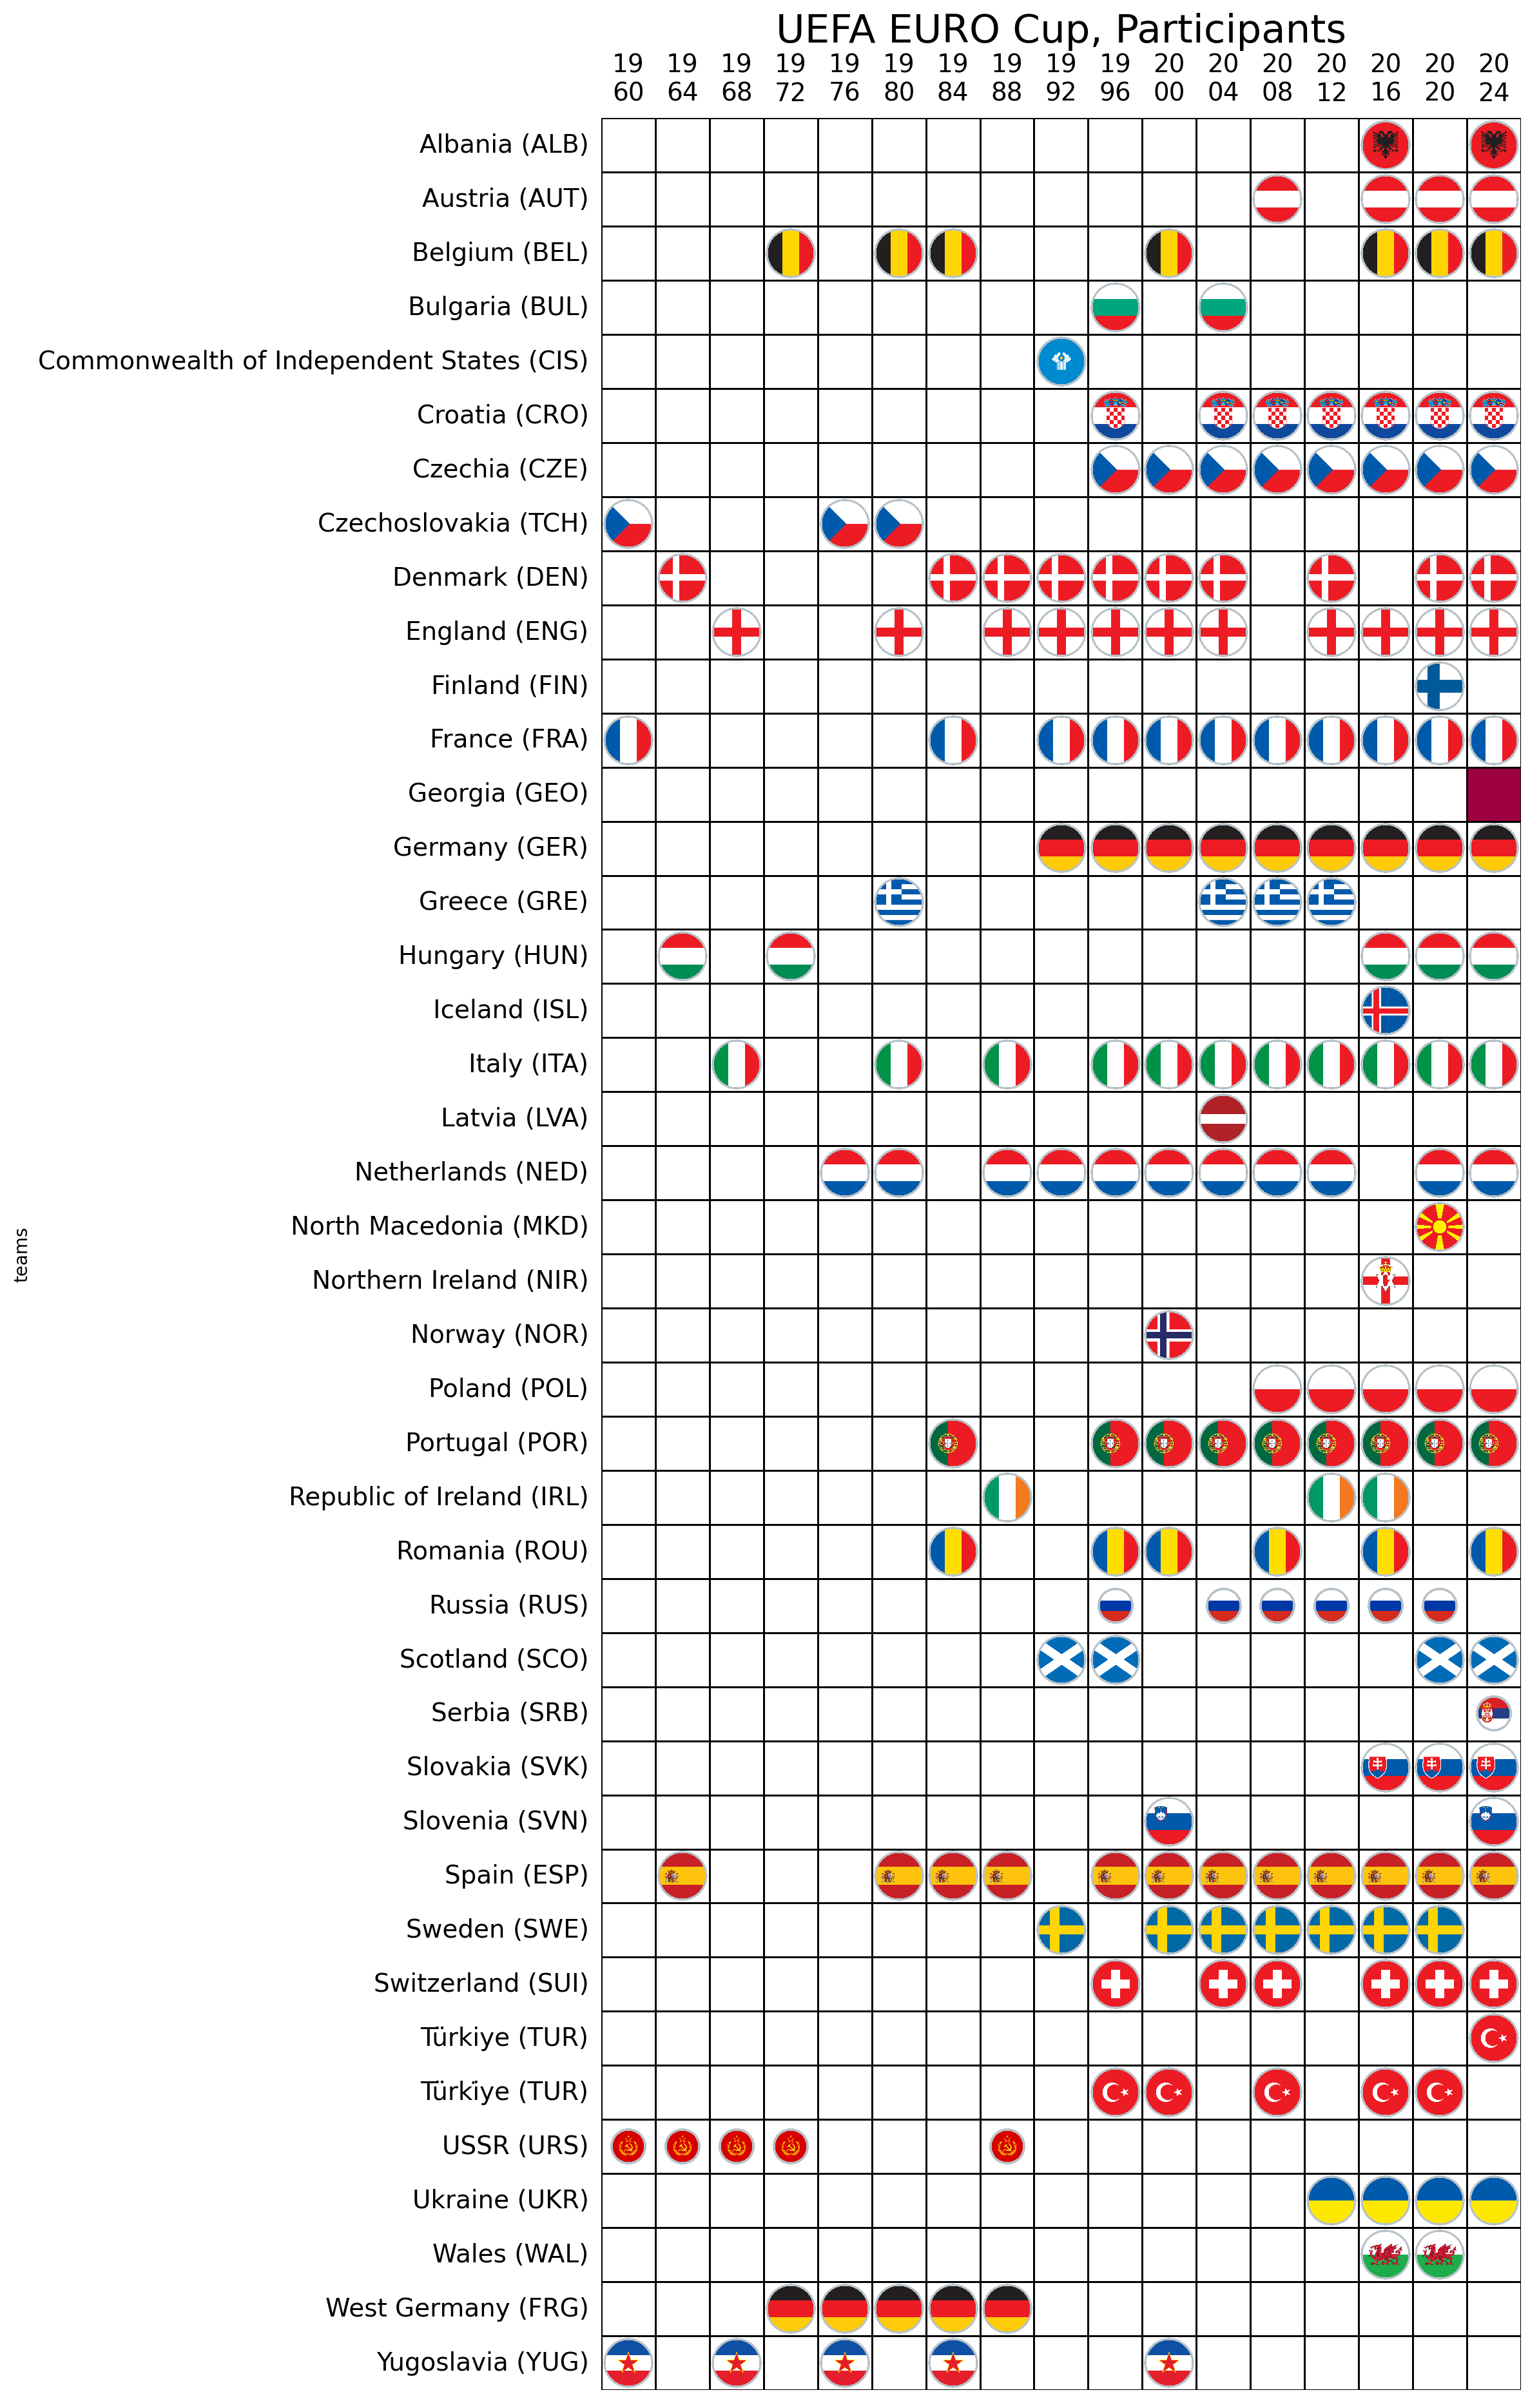

In [51]:
# Group matches by year and aggregate teams
all_matches['home_team_extra'] = all_matches.apply(lambda row: f"{row['home_team']} ({row['home_team_code']})", axis=1)
all_matches['away_team_extra'] = all_matches.apply(lambda row: f"{row['away_team']} ({row['away_team_code']})", axis=1)
df_team = all_matches.groupby('year').agg(home=('home_team_extra', list), away=('away_team_extra', list))
df_team['teams'] = df_team.apply(lambda x: list(set(x['home'] + x['away'])), axis=1)
df_team['#'] = df_team['teams'].apply(len)

# Pivot table for heatmap
df_team_pivot = df_team['teams'].explode().reset_index().pivot(index='year', columns='teams', values='year').T
df_team_pivot[df_team_pivot > 0] = 1
column_list = sorted(df_team.index, reverse=True)

df_team_pivot['times'] = df_team_pivot.sum(axis=1)
df_team_pivot = df_team_pivot.sort_values(['times'] + column_list, ascending=[False] * (len(column_list) + 1))

df_team_pivot.columns = [str(col)[:-2] + '\n' + str(col)[-2:] for col in column_list[::-1]] + ['times']
df_team_pivot = df_team_pivot.drop('times', axis=1)
df_team_pivot = df_team_pivot.sort_index()

# Function to load country logos
def get_image(path):
    return OffsetImage(plt.imread(path), zoom=0.04)

# Function to plot heatmap with logos
def plot_with_logos(data, title, size=(16, 16), is_save=False):
    '''
    Plot heatmap with country logos.
    '''
    dpi = 200
    fig, ax = plt.subplots(figsize=size, dpi=dpi)
    
    # Create a mask for cells without logos
    mask = data.copy()
    mask[:] = False
    
    
    # Customize ticks and labels
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.xaxis.tick_top()
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none') 
    ax.spines[['bottom', 'right']].set_visible(True)
    ax.set_title(title, size=22)
    
    # Add country logos and update the mask
    for (i, j), val in np.ndenumerate(data):
        if val == 1:
            # Extract the country code using regex
            country_code = re.search(r'\((.*?)\)', data.index[i]).group(1)
            try:
                logo_path = f'../inputs/logos/{country_code}.png'
                ab = AnnotationBbox(get_image(logo_path), (j + 0.5, i + 0.5), frameon=False)
                ax.add_artist(ab)
            except FileNotFoundError:
                mask.iloc[i, j] = True  # Mark cell to be colored black
                
    # Plot the heatmap with the mask
    sns.heatmap(data, annot=False, cbar=False, linewidths=0.5, 
                linecolor='black', square=True, cmap='Spectral', ax=ax, mask=~mask, 
                facecolor='black')

    plt.tight_layout()
    if is_save:
        plt.savefig(f'{title.lower()}.png')
    plt.show()

# Title for the plot
title = 'UEFA EURO Cup, Participants'

# Plotting the heatmap with logos
plot_with_logos(df_team_pivot, title=title, size=(12, 32), is_save=True)


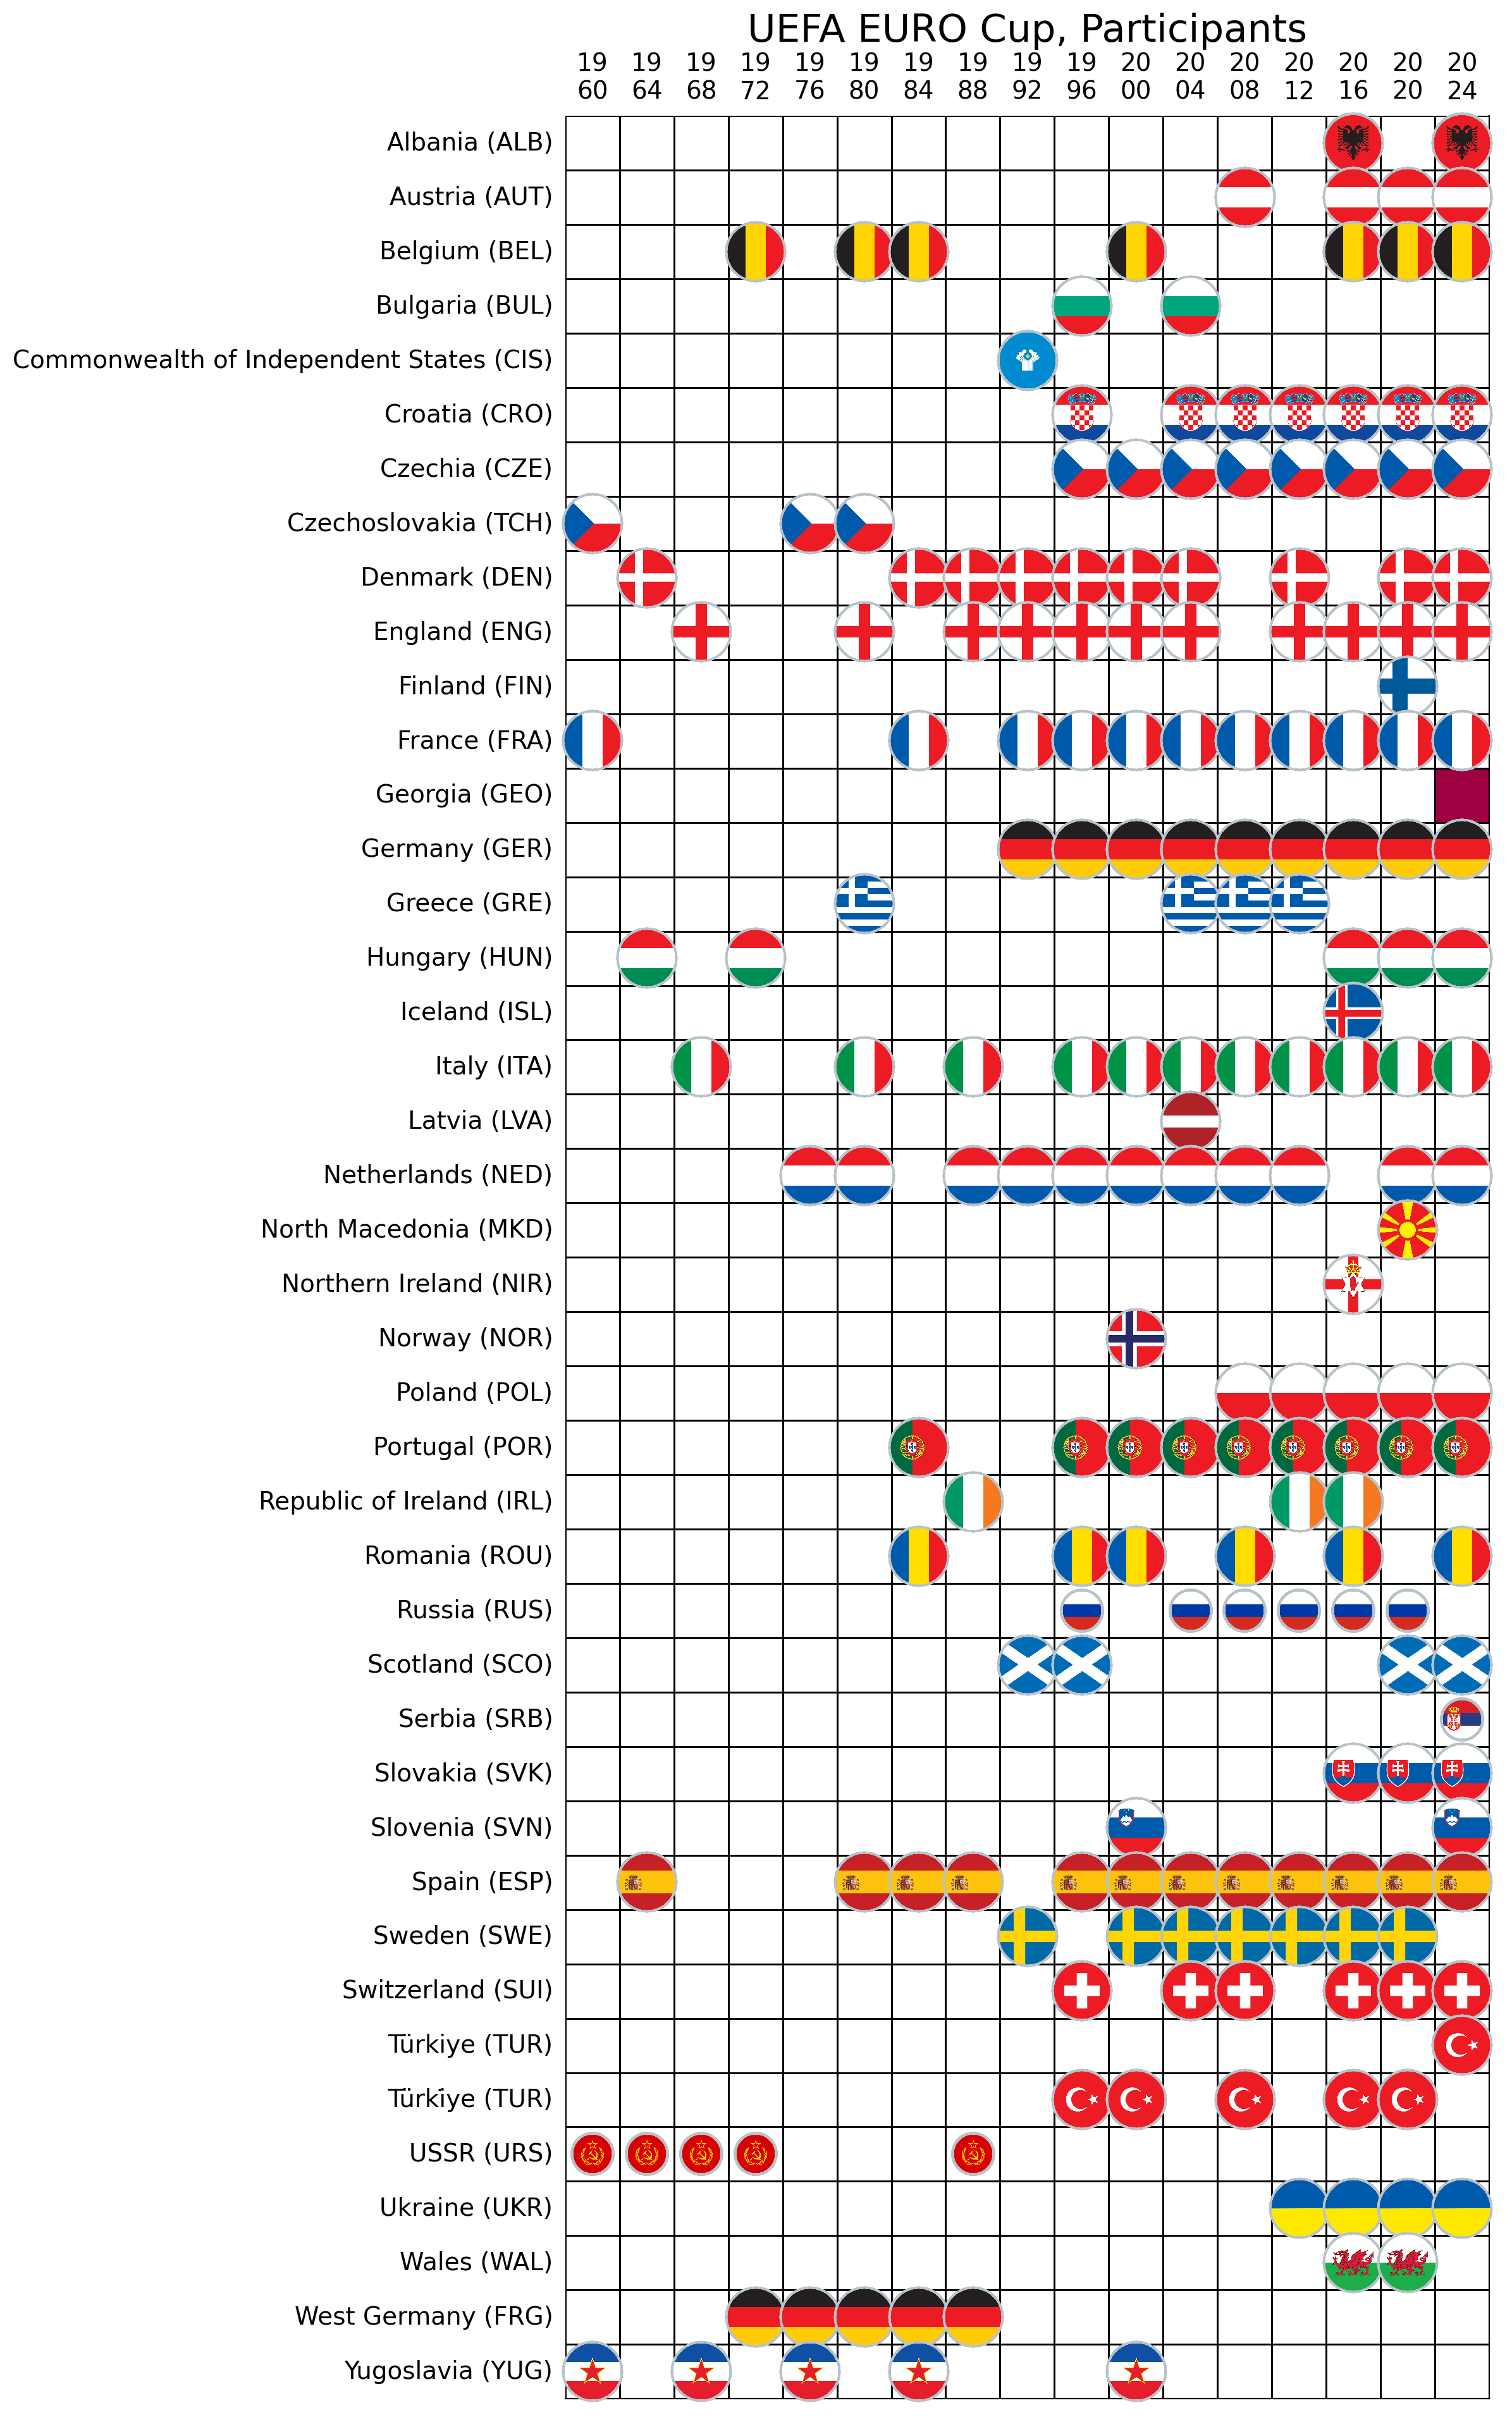

In [50]:
import re
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def get_image(path, zoom=0.04):
    return OffsetImage(plt.imread(path), zoom=zoom)

def plot_with_logos(data, title, size=(16, 16), is_save=False):
    '''
    Plot heatmap with country logos.
    '''
    dpi = 200
    fig, ax = plt.subplots(figsize=size, dpi=dpi)
    
    # Create a mask for cells without logos
    mask = data.copy()
    mask[:] = False
    
    # Add country logos and update the mask
    for (i, j), val in np.ndenumerate(data):
        if val == 1:
            country_name_code = data.index[i]
            match = re.search(r'\((.*?)\)', country_name_code)
            if match:
                country_code = match.group(1)
                try:
                    logo_path = f'../inputs/logos/{country_code}.png'
                    ab = AnnotationBbox(get_image(logo_path, zoom=0.05), (j + 0.5, i + 0.5), frameon=False)
                    ax.add_artist(ab)
                except FileNotFoundError:
                    mask.iloc[i, j] = True  # Mark cell to be colored black

    # Plot the heatmap with the mask
    sns.heatmap(data, annot=False, cbar=False, linewidths=0.5, 
                linecolor='black', square=True, cmap='Spectral', ax=ax, mask=~mask, 
                facecolor='black')
    
    # Customize ticks and labels
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.xaxis.tick_top()
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none') 
    ax.spines[['bottom', 'right']].set_visible(True)
    ax.set_title(title, size=22)

    plt.tight_layout()
    if is_save:
        plt.savefig(f'{title.lower()}.png')
    plt.show()

# Title for the plot
title = 'UEFA EURO Cup, Participants'

# Plotting the heatmap with logos
plot_with_logos(df_team_pivot, title=title, size=(12, 32), is_save=True)